In [1]:

import h5py
import os
import json

import pandas as pd
import numpy as np
import pylab as pl
import matplotlib as mpl
import seaborn as sns

import pyvttbl as pt
from collections import namedtuple


from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


from pipeline.python.utils import natural_keys
import pipeline.python.traces.combine_runs as cb
import pipeline.python.paradigm.align_acquisition_events as acq


/home/juliana/anaconda/envs/rpy/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
np.__version__

'1.11.0'

In [3]:
%matplotlib inline
pd.options.display.mpl_style = 'default'
pl.style.use('ggplot')
mpl.rcParams['font.family'] = ['Bitstream Vera Sans']

/home/juliana/anaconda/envs/rpy/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:

rootdir = '/mnt/odyssey'
animalid = 'CE077'
session = '20180321'
acquisition = 'FOV1_zoom1x'
rundir = 'blobs_run3_blobs_run4'
tracedir = 'traces002_traces002'

trace_type = 'raw'
filter_pupil = True
pupil_radius_min = 20
pupil_radius_max = 60
pupil_dist_thr = 3.0

traceid_dir = os.path.join(rootdir, animalid, session, acquisition, rundir, tracedir)


In [5]:

#%% # Load ROIDATA file:
roidata_filepath = os.path.join(traceid_dir, 'ROIDATA_098054_626d01_raw.hdf5')
DATA = pd.HDFStore(roidata_filepath, 'r')
datakeys = DATA.keys()
print "Found %i data keys" % len(datakeys)
if len(datakeys) == 1:
    datakey = datakeys[0]
print "Loading dataframe..."
DATA = DATA[datakey]


Found 1 data keys
Loading dataframe...


In [6]:
#%% Set filter params:

if filter_pupil is True:
    pupil_params = acq.set_pupil_params(radius_min=pupil_radius_min,
                                        radius_max=pupil_radius_max,
                                        dist_thr=pupil_dist_thr,
                                        create_empty=False)
elif filter_pupil is False:
    pupil_params = acq.set_pupil_params(create_empty=True)

#%% Calculate metrics & get stats ---------------------------------------------

STATS, stats_filepath = cb.get_combined_stats(DATA, datakey, traceid_dir, trace_type=trace_type, filter_pupil=filter_pupil, pupil_params=pupil_params)



Requested METRIC: pupil_rmin20.00-rmax60.00-dist3.00_6615351009669783841
Found metrics: ['pupil_rmin20.00-rmax60.00-dist3.00_1411596562211147165']
Renaming metric description string to existing.
Renamed hash to match existing.
Saved roiparams to .json
Retrieved existing STATS file:
/mnt/odyssey/CE077/20180321/FOV1_zoom1x/blobs_run3_blobs_run4/traces002_traces002/metrics/pupil_rmin20.00-rmax60.00-dist3.00_1411596562211147165/roi_stats_1411596562211147165_raw_20180404120045.hdf5


In [174]:
#%%

trial_list = sorted(list(set(STATS['trial'])), key=natural_keys)
roi_list = sorted(list(set(STATS['roi'])), key=natural_keys)

roi = roi_list[0]
roiSTATS = STATS[STATS['roi']==roi]
grouped = roiSTATS.groupby(['config', 'trial']).agg({'stim_df': 'mean',
                                                         'baseline_df': 'mean'
                                                        }).dropna()

rstats_df = roiSTATS[['config', 'trial', 'baseline_df', 'stim_df', 'xpos', 'ypos', 'morphlevel', 'yrot', 'size']]
rstats_df = roiSTATS[['config', 'trial', 'baseline_df', 'stim_df']].dropna()

tmpd = rstats_df.pivot_table(['stim_df', 'baseline_df'], ['config', 'trial']).T

data = []
data.append(pd.DataFrame({'epoch': np.tile('baseline', (len(tmpd.loc['baseline_df'].values),)),
              'df': tmpd.loc['baseline_df'].values,
              'config': [cfg[0] for cfg in tmpd.loc['baseline_df'].index.tolist()],
              'trial': [cfg[1] for cfg in tmpd.loc['baseline_df'].index.tolist()]
              }))
data.append(pd.DataFrame({'epoch': np.tile('stimulus', (len(tmpd.loc['stim_df'].values),)),
              'df': tmpd.loc['stim_df'].values,
              'config': [cfg[0] for cfg in tmpd.loc['baseline_df'].index.tolist()],
              'trial': [cfg[1] for cfg in tmpd.loc['baseline_df'].index.tolist()]
              }))
data = pd.concat(data)

# #%%
# #subd = data[['config', 'df', 'epoch']]

# interaction_plot(data.epoch, data.config, data.df,
#              colors=[np.random.rand(3,) for c in range(9)],
#              markers=['.','D','_','|','*','v','^','<','>'], ms=10)

config_list = sorted(list(set(data.config)), key=natural_keys)


In [8]:
trial_list = sorted(list(set(data.trial)), key=natural_keys)
print len(trial_list)

145


In [130]:
tmpd.T.shape

(145, 2)

# PTL_ANOVA2

In [118]:
from scipy.stats import f

# import warnings
# warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


def ssd(ser):
    '''
    Function ssd(): computes the sum of squared deviates for a Series object
    
    > Input parameters:
    - ser: the Series object
    
    > Returns:
    - The sum of squared deviates computed as Σ(x)**2 - ((Σx)**2)/N  
    '''
    ser.dropna(axis=0, inplace=True)     # Clear Series from null values 'in place'
    s1 = pow(ser,2).sum()
    s2 = pow(ser.sum(),2) / ser.size
    return s1-s2



def ssd_df(indf):
    '''
    Function ssd_df(): computes the ssd: Σ(x)**2 - ((Σx)**2)/N factor for a DataFrame object as a whole
      
    > Input parameters:
    - df: the DataFrame object
    It is ALWAYS assumed that the 1st column (0-index) is the R-factor and is ommited from computations
    
    > Returns a tuple consisting of:
    - ss_n_all = The ssd: Σ(x)**2 - ((Σx)**2)/N factor 
    - n_all = The size of DataFrame data included in the computation 
    '''
    
    n_all = sumx = sumx2 = 0
    for i in range(1,len(indf.columns)):
        ser = indf.iloc[:,i].dropna()
        sumx += ser.sum()
        sumx2 += pow(ser,2).sum()
        n_all += ser.size        
    sumx_sqed = pow(sumx,2)
    ss_n_all = sumx2 - (sumx_sqed / n_all)
    return ss_n_all, n_all



def ssd_df_rc(df, axis=0):
    '''
    Function ssd_df_rc(): computes the sum of squared deviates for the two way anova rows or columns  
    This sum is computed as Σ((Σ(x)**2)/Ν) - ((Σx_all)**2)/N_all
    It is ALWAYS assumed that the 1st column (0-index) is the R-factor and is ommited from computations
    
    > Input parameters:
    - df: the DataFrame object
    - axis=0 column-wise (working on columns data)
    - axis=1 row-wise (working on rows data) 
    
    > Returns:
    - The sum of squared deviates for the anova rows or columns of the input DataFrame
    '''
    
    ss_n_sum = 0
    ss_n_all = 0
    
    if axis == 0:
        # Compute the ss_n_sum quantity considering each SEPARATE Column in df 
        for i in range(1,len(df.columns)):
            c_ser = df.iloc[:,i].dropna()
            ss_n_sum += pow(c_ser.sum(),2) / c_ser.size
    
    elif axis == 1:
        r_factor = df.columns[0]
        anv_groups = df.groupby(r_factor)
        for symb, gp in anv_groups:
            # Compute the ss_n_sum quantity considerint each SEPARATE Row in df
            # Rows in df are ADDED columns in each anv_groups
            n_all = sumx = 0
            for i in range(1,len(gp.columns)):
                ser = gp.iloc[:,i].dropna()
                sumx += ser.sum()
                n_all += ser.size        
            ss_n_sum += pow(sumx,2) / n_all

    else:
        print('axis undefined in ssd_df_rc()')
        return 

    # Compute the ((Σx_all)**2)/N_all factor for ALL data in the DataFrame
    n_all = sumx = sumx_p2 = 0
    for i in range(1,len(df.columns)):
        ser = df.iloc[:,i].dropna()
        sumx += ser.sum()
        n_all += ser.size        
    sumx_sqed = pow(sumx,2)
    ss_n_all = sumx_sqed / n_all
    
    return ss_n_sum - ss_n_all

### Format data:

In [178]:
data = data[['config', 'epoch','df']]
# rstats = rstats_df[['config', 'baseline_df', 'stim_df']]

In [198]:
data.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
           dtype='int64', length=290)

In [199]:
D = data.pivot_table(index=range(, columns=['config', 'epoch'], values='df')

AttributeError: 'Series' object has no attribute 'columns'

In [202]:
D.shape

(145, 18)

In [152]:
rstats_df.pivot_table(index='trial', values=['stim_df', 'baseline_df'], columns=['config']).T

trial                    trial00003    trial00004    trial00009    trial00012  \
            config                                                              
baseline_df config001           NaN           NaN           NaN           NaN   
            config002           NaN           NaN           NaN           NaN   
            config003           NaN           NaN -3.947460e-17           NaN   
            config004           NaN           NaN           NaN           NaN   
            config005           NaN -1.727014e-17           NaN           NaN   
            config006           NaN           NaN           NaN           NaN   
            config007           NaN           NaN           NaN           NaN   
            config008 -8.002858e-17           NaN           NaN  1.767105e-16   
            config009           NaN           NaN           NaN           NaN   
stim_df     config001           NaN           NaN           NaN           NaN   
            config002           NaN           NaN           NaN           NaN   
            config003           NaN           NaN  2.030433e-01           NaN   
            config004           NaN           NaN           NaN           NaN   
            config005           NaN -1.003397e-01           NaN           NaN   
            config006           NaN           NaN           NaN           NaN   
            config007           NaN           NaN           NaN           NaN   
            config008  5.280574e-01           NaN           NaN  1.773848e-01   
            config009           NaN           NaN           NaN           NaN   

trial                    trial00014    trial00015    trial00016    trial00017  \
            config                                                              
baseline_df config001           NaN           NaN           NaN           NaN   
            config002           NaN           NaN -1.281382e-16           NaN   
            config003           NaN           NaN           NaN           NaN   
            config004           NaN           NaN           NaN  1.067048e-16   
            config005           NaN -2.670703e-16           NaN           NaN   
            config006           NaN           NaN           NaN           NaN   
            config007           NaN           NaN           NaN           NaN   
            config008           NaN           NaN           NaN           NaN   
            config009 -1.124872e-16           NaN           NaN           NaN   
stim_df     config001           NaN           NaN           NaN           NaN   
            config002           NaN           NaN  1.984708e-01           NaN   
            config003           NaN           NaN           NaN           NaN   
            config004           NaN           NaN           NaN  9.232919e-02   
            config005           NaN  4.255083e-01           NaN           NaN   
            config006           NaN           NaN           NaN           NaN   
            config007           NaN           NaN           NaN           NaN   
            config008           NaN           NaN           NaN           NaN   
            config009  1.710143e-01           NaN           NaN           NaN   

trial                    trial00018    trial00019      ...         trial00348  \
            config                                     ...                      
baseline_df config001           NaN           NaN      ...                NaN   
            config002           NaN           NaN      ...                NaN   
            config003           NaN           NaN      ...       5.150201e-17   
            config004           NaN  1.279840e-17      ...                NaN   
            config005           NaN           NaN      ...                NaN   
            config006           NaN           NaN      ...                NaN   
            config007 -1.326100e-17           NaN      ...                NaN   
            config008        

In [143]:
data.pivot(index='trial', values='df')

ValueError: cannot label index with a null key

In [203]:
 # Computing ss_t and n_t with the ss_df() function
ss_t, n_t = ssd_df(D)
    

In [204]:
ss_t

9.9870818652790803

In [210]:
D.columns[0]

(u'config001', 'baseline')

In [207]:
inframe = D.copy()

In [208]:
# Detecting the shape of inframe:
rows, cols = inframe.shape

# Detecting the R x C anova design 
c = len(inframe.columns)-1
r_factor = inframe.columns[0]
anv_groups = inframe.groupby(r_factor)
r = len(anv_groups)

ValueError: Grouper for 'config001' not 1-dimensional

# PYVTTBL

In [19]:


N = 20
P = [1,2]
Q = [1,2,3]

values = [[998,511], [1119,620], [1300,790]]

sub_id = [i+1 for i in xrange(N)]*(len(P)*len(Q))
mus = np.concatenate([np.repeat(value, N) for value in values]).tolist()
rt = np.random.normal(mus, scale=112.0, size=N*len(P)*len(Q)).tolist()
iv1 = np.concatenate([np.array([p]*N) for p in P]*len(Q)).tolist()
iv2 = np.concatenate([np.array([q]*(N*len(P))) for q in Q]).tolist()
 
 
Sub = namedtuple('Sub', ['Sub_id', 'rt','iv1', 'iv2'])               
df = pt.DataFrame()
 
for idx in xrange(len(sub_id)):
    df.insert(Sub(sub_id[idx],rt[idx], iv1[idx],iv2[idx])._asdict())    

In [27]:
df.shape()

(4, 120)

In [8]:

# N = 20
# P = data.epoch)
# Q = [1,2,3]
epoch_list = list(set(data.epoch))
config_list = list(set(data.config))
trial_list = list(set(data.trial))

# values = [[998,511], [1119,620], [1300,790]]

sub_id = [trial_list.index(i) for i in data['trial'].tolist()]
#mus = np.concatenate([np.repeat(value, N) for value in values]).tolist()
rt = data['df'].tolist()
iv1 = [epoch_list.index(i) for i in data['epoch'].tolist()]
iv2 = [config_list.index(i) for i in data['config'].tolist()]
 
 
Sub = namedtuple('Sub', ['Sub_id', 'rt','iv1', 'iv2'])               
ptdf = pt.DataFrame()
 
for idx in xrange(len(sub_id)):
    ptdf.insert(Sub(sub_id[idx],rt[idx], iv1[idx],iv2[idx])._asdict())    

In [19]:
ptdf.shape()

(4, 290)

In [28]:
tmpd

config          config001                                            \
trial          trial00024    trial00048    trial00063    trial00113   
baseline_df  2.171103e-16 -2.528841e-17 -2.831069e-16  1.850372e-17   
stim_df      4.193878e-01  2.697541e-01  9.082100e-02 -6.856510e-02   

config                                                               \
trial          trial00122    trial00143    trial00146    trial00161   
baseline_df -1.554312e-16 -8.635068e-17  2.559681e-16  1.233581e-17   
stim_df      1.534522e-01  1.823523e-01  6.188625e-02 -7.937990e-02   

config                                       ...          config009  \
trial          trial00164    trial00172      ...         trial00111   
baseline_df -7.586524e-17  1.467962e-16      ...       5.057683e-17   
stim_df     -1.142382e-01 -3.038662e-02      ...       3.254518e-01   

config                                                               \
trial          trial00136    trial00160    trial00165    trial00184   
baseline_df  8.758426e-17  3.731583e-17 -1.731640e-16  7.247289e-17   
stim_df      4.195949e-01 -1.496757e-02  4.743603e-02  9.337281e-02   

config                                                               \
trial          trial00190    trial00205    trial00243    trial00252   
baseline_df  1.393947e-16  7.154771e-17 -2.775558e-17 -2.501086e-16   
stim_df      1.058705e-01  2.868778e-01  5.446454e-01  6.286838e-01   

config                     
trial          trial00347  
baseline_df  2.675329e-17  
stim_df      2.245448e-01  

[2 rows x 145 columns]

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

/home/juliana/anaconda/envs/rpy/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


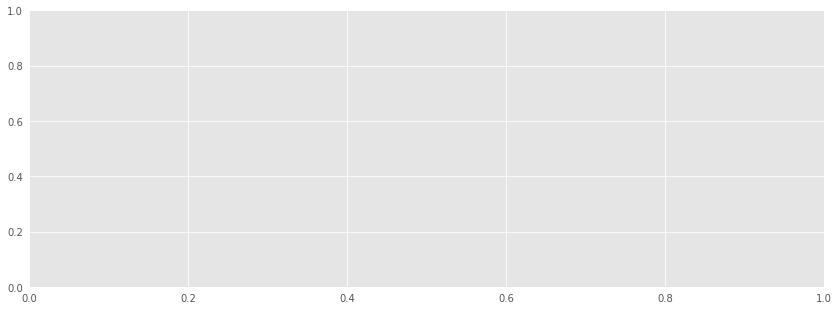

In [10]:
ptdf.box_plot('rt', factors=['iv1', 'iv2'])

In [22]:
#ptdf.box_plot('rt', factors=['iv1', 'iv2'])
aov = ptdf.anova('rt', sub='Sub_id', wfactors=['iv1', 'iv2'])


In [33]:
aov

Anova([(('iv1',),
        {'F': 101.60204298540206,
         'F_gg': 101.60204298540206,
         'F_hf': 101.60204298540206,
         'F_lb': 101.60204298540206,
         'ci': 0.0029410777389656641,
         'ci_gg': 0.0029410777389656641,
         'ci_hf': 0.0029410777389656641,
         'ci_lb': 0.0029410777389656641,
         'critT': 1.9765750658185368,
         'critT_gg': 1.9765750658185368,
         'critT_hf': 1.9765750658185368,
         'critT_lb': 1.9765750658185368,
         'df': 1,
         'df_gg': 1.0,
         'df_hf': 1.0,
         'df_lb': 1.0,
         'dfe': 144.0,
         'dfe_gg': 144.0,
         'dfe_hf': 144.0,
         'dfe_lb': 144.0,
         'eps_gg': 1.0,
         'eps_hf': 1.0,
         'eps_lb': 1.0,
         'eta': 0.030125336947549049,
         'lambda': 920.76851455520591,
         'lambda_gg': 920.76851455520591,
         'lambda_hf': 920.76851455520591,
         'lambda_lb': 920.76851455520591,
         'mse': 0.0028893283217501565,
         'mse

In [43]:
def extract_for_apa(factor, aov, values = ['F', 'mse', 'eta', 'p']):
    results = {}
    for key,result in aov[factor].iteritems():
        if key in values:
            results[key] = result
            
    return results

In [44]:
aov.keys()

[('iv1',), ('iv2',), ('iv1', 'iv2')]

In [45]:
keys = ['iv1', 'iv2', 'iv1, iv2']

In [46]:
results = {}
for factorkey in aov.keys():
    results[factorkey] = extract_for_apa(factorkey, aov, values = ['F', 'mse', 'eta', 'p'])
results

{('iv1',): {'F': 101.60204298540206,
  'eta': 0.030125336947549049,
  'mse': 0.0028893283217501565,
  'p': 2.0651289937838327e-18},
 ('iv1', 'iv2'): {'F': 1.2112775856007068,
  'eta': 0.0048595356091884756,
  'mse': 0.0048868445376710132,
  'p': 0.28859748715877442},
 ('iv2',): {'F': 2.0002358558681714,
  'eta': 0.004679609373764446,
  'mse': 0.002849743878104155,
  'p': 0.043348085909278931}}

In [27]:
rows, cols = data.shape
print rows, cols

290 4


# Interactive R

In [1]:
from rpy2.robjects import r


In [2]:
import itertools

In [3]:
epoch_types = list(set(data.epoch))
config_types = list(set(data.config))

factor_list = list(itertools.product(epoch_types, config_types))
factor_list = sorted(factor_list, key=lambda x: x[0])
factor_list

NameError: name 'data' is not defined

In [27]:
dflist = [data[((data['epoch']==factorpair[0]) & (data['config'] == factorpair[1]))]['df'] for factorpair in factor_list]

In [28]:
for factorpair, dfvalues in zip(factor_list, dflist):
    currcond = '%s_%s' % (factorpair[1], factorpair[0])
    print currcond
    globals()[currcond] = dfvalues.values
    #r.assign(currcond, df)
    #exec("%s=%s" % (currcond, dfvalues))

config007_baseline
config006_baseline
config005_baseline
config004_baseline
config003_baseline
config002_baseline
config001_baseline
config009_baseline
config008_baseline
config007_stimulus
config006_stimulus
config005_stimulus
config004_stimulus
config003_stimulus
config002_stimulus
config001_stimulus
config009_stimulus
config008_stimulus


In [13]:
config001_stimulus

array([ 0.41938776,  0.26975406,  0.090821  , -0.0685651 ,  0.15345224,
        0.18235229,  0.06188625, -0.0793799 , -0.1142382 , -0.03038662,
        0.05351223,  0.5483637 ,  0.07020781,  0.03384073, -0.21023755])

In [14]:
%load_ext rpy2.ipython

In [15]:
from rpy2.robjects.packages import importr
utils = importr('utils')
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

packnames = ('car')
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(packnames))

rpy2.rinterface.NULL

In [29]:
#pop the data into R
%Rpush config001_stimulus config002_stimulus config003_stimulus config004_stimulus config005_stimulus config006_stimulus config007_stimulus config008_stimulus config009_stimulus

#label the conditions
%R Factor1 <- c('stimulus','stimulus','stimulus', 'stimulus','stimulus','stimulus','stimulus','stimulus','stimulus','baseline', 'baseline', 'baseline', 'baseline', 'baseline', 'baseline', 'baseline', 'baseline', 'baseline')
%R Factor2 <- c('config001','config002','config003','config004','config005','config006','config007', 'config008', 'config009')


array(['config001', 'config002', 'config003', 'config004', 'config005',
       'config006', 'config007', 'config008', 'config009'], 
      dtype='|S9')

In [30]:

#create a vector of conditions
%R idata <- data.frame(Factor1, Factor2)


,Factor1,Factor2
1,stimulus,config001
2,stimulus,config002
3,stimulus,config003
4,stimulus,config004
5,stimulus,config005
6,stimulus,config006
7,stimulus,config007
8,stimulus,config008
9,stimulus,config009
10,baseline,config001


In [31]:

#combine data into single matrix
%R Bind <- cbind(config001_stimulus, config002_stimulus, config003_stimulus, config004_stimulus, config005_stimulus, config006_stimulus, config007_stimulus, config008_stimulus, config009_stimulus, config001_baseline, config002_baseline, config003_baseline, config004_baseline, config005_baseline, config006_baseline, config007_baseline, config008_baseline, config009_baseline)


array([[  4.19387759e-01,   1.98470793e-01,   2.03043286e-01,
          9.23291900e-02,  -1.00339730e-01,   6.76284860e-01,
          1.74249438e-01,   5.28057355e-01,   1.71014332e-01,
          2.17110280e-16,  -1.28138241e-16,  -3.94745964e-17,
          1.06704768e-16,  -1.72701359e-17,  -2.39623136e-16,
         -1.32609972e-17,  -8.00285764e-17,  -1.12487180e-16],
       [  2.69754057e-01,   2.37851137e-01,   3.84639145e-02,
          7.71276949e-02,   4.25508297e-01,   3.47245612e-01,
         -6.18997069e-02,   1.77384845e-01,   4.22168894e-01,
         -2.52884133e-17,   3.26899002e-17,  -2.58435249e-16,
          1.27984043e-17,  -2.67070316e-16,  -7.15477060e-17,
         -2.01998911e-16,   1.76710498e-16,   1.44945784e-16],
       [  9.08209973e-02,   4.95849577e-02,   1.14709883e-01,
          4.75223069e-01,   8.42826080e-02,   2.05088084e-01,
         -4.24266421e-02,   8.18594803e-01,   1.36483784e+00,
         -2.83106871e-16,  -1.17498603e-16,  -1.35693925e-17,
      

In [32]:

#generate linear model
%R model <- lm(Bind~1)


R object with classes: ('mlm', 'lm') mapped to:
<ListVector - Python:0x7f1ac9389098 / R:0x90b6768>
[Matrix, Matrix, Matrix, ..., Vector, Formula, DataF...]
  coefficients: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7f1ac9389050 / R:0x3d34250>
[0.120041, 0.227488, 0.091807, ..., -0.000000, -0.000000, 0.000000]
  residuals: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7f1ac9389248 / R:0x90b2580>
[0.299347, 0.149713, -0.029220, ..., -0.000000, 0.000000, 0.000000]
  effects: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7f1ac9389128 / R:0x90b2fd0>
[-0.509290, 0.092615, -0.086318, ..., -0.000000, 0.000000, 0.000000]
  ...
  coefficients: <class 'rpy2.robjects.vectors.Vector'>
  R object with classes: ('mlm', 'lm') mapped to:
<Vector - Python:0x7f1ac93895a8 / R:0x81f93a8>
[RNULLType, Vector]
  residuals: <class

In [33]:

#load the car library. note this library must be installed.
%R library(car)


array(['car', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='|S9')

In [34]:


%R analysis <- Anova(model, idata=idata, idesign=~Factor1*Factor2, type="III")


R object with classes: ('Anova.mlm',) mapped to:
<ListVector - Python:0x7f1ac93719e0 / R:0x5b4d248>
[ListV..., ListV..., ListV..., ..., StrVe..., RNULL..., BoolV...]
R object with classes: ('Anova.mlm',) mapped to:
<ListVector - Python:0x7f1ac93719e0 / R:0x5b4d248>
[ListV..., ListV..., ListV..., ..., StrVe..., RNULL..., BoolV...]
R object with classes: ('Anova.mlm',) mapped to:
<ListVector - Python:0x7f1ac93719e0 / R:0x5b4d248>
[ListV..., ListV..., ListV..., ..., StrVe..., RNULL..., BoolV...]
R object with classes: ('Anova.mlm',) mapped to:
<ListVector - Python:0x7f1ac93719e0 / R:0x5b4d248>
[ListV..., ListV..., ListV..., ..., StrVe..., RNULL..., BoolV...]
  ...
  SSP: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f1ac9371878 / R:0x93c9de8>
[str, str]
  SSPE: <type 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL
  P: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolV

In [35]:

#create anova summary table
%R anova_sum = summary(analysis)

#move the data from R to python
%Rpull anova_sum


In [36]:
print anova_sum


Type III Repeated Measures MANOVA Tests:

------------------------------------------
 
Term: (Intercept) 

 Response transformation matrix:
                   (Intercept)
config001_stimulus           1
config002_stimulus           1
config003_stimulus           1
config004_stimulus           1
config005_stimulus           1
config006_stimulus           1
config007_stimulus           1
config008_stimulus           1
config009_stimulus           1
config001_baseline           1
config002_baseline           1
config003_baseline           1
config004_baseline           1
config005_baseline           1
config006_baseline           1
config007_baseline           1
config008_baseline           1
config009_baseline           1

Sum of squares and products for the hypothesis:
            (Intercept)
(Intercept)    63.21486

Multivariate Tests: (Intercept)
                 Df test stat approx F num Df den Df     Pr(>F)    
Pillai            1  0.868421 112.1999      1     17 6.6169e-09 ***
Wilk

# ANOVA2

In [74]:
inputd = data[['config', 'df', 'epoch']]

In [75]:
x = inputd.groupby(['epoch', 'config'])['df'].apply(list).apply(pd.Series).T

In [76]:
x

epoch       baseline                                                          \
config     config001     config002     config003     config004     config005   
0       2.171103e-16 -1.281382e-16 -3.947460e-17  1.067048e-16 -1.727014e-17   
1      -2.528841e-17  3.268990e-17 -2.584352e-16  1.279840e-17 -2.670703e-16   
2      -2.831069e-16 -1.174986e-16 -1.356939e-17  1.775586e-16  5.427757e-17   
3       1.850372e-17  3.238150e-17  1.215077e-16  1.912051e-16  5.211880e-17   
4      -1.554312e-16  3.515706e-17 -9.159340e-17  3.031526e-16 -2.226614e-16   
5      -8.635068e-17 -3.423188e-17  1.857311e-16  1.085551e-16 -3.515706e-17   
6       2.559681e-16  6.938894e-17 -1.301428e-16 -6.352943e-17  1.851962e-16   
7       1.233581e-17  2.615963e-16 -1.958310e-16  1.668418e-16  1.013079e-16   
8      -7.586524e-17 -3.639064e-17  1.529641e-16 -2.590520e-17  3.700743e-18   
9       1.467962e-16 -2.729298e-17 -1.332268e-16 -3.096289e-16 -4.194176e-17   
10     -1.504969e-16  2.220446e-17  7.925759e-17  7.185610e-17  7.401487e-18   
11      2.513422e-17 -4.024558e-17  2.090920e-16 -8.789266e-18 -1.588236e-16   
12     -8.866364e-17  6.784696e-17  5.150201e-17  1.213535e-16 -8.018277e-17   
13      1.104055e-16 -2.673787e-16  3.943605e-17  1.541976e-17 -1.665335e-17   
14      3.700743e-17 -5.396917e-17           NaN  9.436896e-17 -1.110223e-17   
15               NaN -1.178070e-16           NaN  2.290606e-16  1.805654e-16   
16               NaN -8.264994e-17           NaN  3.083953e-17  6.013708e-18   
17               NaN -3.059281e-16           NaN           NaN  4.163336e-18   

epoch                                                           stimulus  \
config     config006     config007     config008     config009 config001   
0      -2.396231e-16 -1.326100e-17 -8.002858e-17 -1.124872e-16  0.419388   
1      -7.154771e-17 -2.019989e-16  1.767105e-16  1.449458e-16  0.269754   
2       2.201942e-16  1.196574e-16  1.585152e-16 -6.198745e-17  0.090821   
3       1.640663e-16 -2.467162e-18  1.510366e-16  5.057683e-17 -0.068565   
4      -1.711594e-16  1.418618e-17  6.908054e-17  8.758426e-17  0.153452   
5       1.033895e-16 -1.541976e-17 -2.346888e-16  3.731583e-17  0.182352   
6      -1.529641e-16 -1.344603e-16 -2.092848e-16 -1.731640e-16  0.061886   
7       1.332268e-16 -2.838779e-16 -3.268990e-16  7.247289e-17 -0.079380   
8       3.682625e-16  8.018277e-17  1.245917e-16  1.393947e-16 -0.114238   
9       2.348430e-16  5.982869e-17  9.704814e-17  7.154771e-17 -0.030387   
10     -8.307398e-17 -1.696174e-16  1.423244e-16 -2.775558e-17  0.053512   
11      9.375217e-17 -7.632783e-17 -5.150201e-17 -2.501086e-16  0.548364   
12     -1.031582e-16 -1.141063e-17 -1.042376e-16  2.675329e-17  0.070208   
13      1.788693e-17 -2.374644e-16  8.172475e-18           NaN  0.033841   
14     -7.586524e-17 -4.217306e-17 -7.987438e-17           NaN -0.210238   
15     -1.151664e-17  1.048544e-17 -7.648203e-17           NaN       NaN   
16               NaN -2.343804e-17           NaN           NaN       NaN   
17               NaN -3.042319e-16           NaN           NaN       NaN   

epoch                                                                         \
config config002 config003 config004 config005 config006 config007 config008   
0       0.198471  0.203043  0.092329 -0.100340  0.676285  0.174249  0.528057   
1       0.237851  0.038464  0.077128  0.425508  0.347246 -0.061900  0.177385   
2       0.049585  0.114710  0.475223  0.084283  0.205088 -0.042427  0.818595   
3       0.135270  0.391496  0.158232  0.360692  0.039257  0.418481  0.236161   
4       0.146216 -0.011999  0.630929  0.239237  0.674700  0.493305  0.076047   
5       0.142131  0.133402 -0.017001  0.206091 -0.108594 -0.039258  0.020979   
6       0.693043 -0.030931 -0.009206  0.540295  0.027456  0.009346  0.339164   
7       0.178682 -0.096365  0.168113 -0.025961  0.385177  0.150453 -0.192342   
8       0.265028  0.038802  0.160015  0.350026  0.210434  0.095508  0.493835  

In [211]:
level_values = x.columns.to_series().reset_index().drop(0,axis=1)
level_names = x.columns.names


In [213]:
level_values

,epoch,config
0,baseline,config001
1,baseline,config002
2,baseline,config003
3,baseline,config004
4,baseline,config005
5,baseline,config006
6,baseline,config007
7,baseline,config008
8,baseline,config009
9,stimulus,config001


In [212]:
level_names

FrozenList([u'epoch', u'config'])

In [214]:
_dummy_data_anova2 = pd.DataFrame(np.random.rand(30,4) + [[0., 1., 0.2, 0.8]],
                           columns=pd.MultiIndex.from_tuples([
                           ('a0','b0'),('a0','b1'),('a1','b0'),('a1','b1')],
                           names=['factor_a', 'factor_b']),
                           index=range(30))

In [215]:
_dummy_data_anova2

factor_a        a0                  a1          
factor_b        b0        b1        b0        b1
0         0.067868  1.549922  0.673209  1.137240
1         0.978547  1.539549  0.344754  1.316852
2         0.427613  1.153280  0.264952  1.763619
3         0.870652  1.122188  1.189855  0.943413
4         0.120344  1.254311  1.093496  0.951543
5         0.614210  1.405602  1.110991  1.240581
6         0.331892  1.404988  0.298655  1.488919
7         0.888026  1.993175  0.856262  1.456325
8         0.501104  1.569907  0.282237  1.094007
9         0.102935  1.823674  0.478612  1.040975
10        0.907989  1.660636  1.192154  1.296002
11        0.043937  1.268853  0.924055  1.632130
12        0.664385  1.646477  0.678675  1.762058
13        0.787205  1.368602  0.790664  1.561786
14        0.848462  1.020216  1.091646  1.051003
15        0.452288  1.341659  0.726271  1.693273
16        0.616272  1.112604  0.744059  1.184040
17        0.748361  1.316087  0.331577  1.515299
18        0.980545  1.973477  1.070403  1.473419
19        0.454255  1.724387  0.230901  1.573596
20        0.698252  1.339045  0.523365  1.126160
21        0.762422  1.135777  0.509011  1.587658
22        0.190178  1.532845  0.632217  1.501405
23        0.208546  1.012132  0.344444  1.082191
24        0.596021  1.904867  1.161726  1.325318
25        0.966895  1.851812  0.285628  1.215584
26        0.767401  1.795419  0.289806  1.600795
27        0.634022  1.313865  1.072096  1.759782
28        0.888000  1.912150  1.040173  0.871665
29        0.223593  1.514178  0.366384  1.242875

In [219]:
anova2(_dummy_data_anova2, print_summary=True)


Type III Repeated Measures MANOVA Tests:

------------------------------------------
 
Term: (Intercept) 

 Response transformation matrix:
     (Intercept)
a0b0           1
a0b1           1
a1b0           1
a1b1           1

Sum of squares and products for the hypothesis:
            (Intercept)
(Intercept)    504.2319

Multivariate Tests: (Intercept)
                 Df test stat approx F num Df den Df     Pr(>F)    
Pillai            1   0.97654 1207.153      1     29 < 2.22e-16 ***
Wilks             1   0.02346 1207.153      1     29 < 2.22e-16 ***
Hotelling-Lawley  1  41.62598 1207.153      1     29 < 2.22e-16 ***
Roy               1  41.62598 1207.153      1     29 < 2.22e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

------------------------------------------
 
Term: factor_a 

 Response transformation matrix:
     factor_a1
a0b0         1
a0b1         1
a1b0        -1
a1b1        -1

Sum of squares and products for the hypothesis:
           factor

ANOVA2(univariate_tests=                           SS  num Df  Error SS  den Df            F  \
(Intercept)        126.057978     1.0  3.028349    29.0  1207.153385   
factor_a             0.005550     1.0  2.286950    29.0     0.070381   
factor_b            18.495149     1.0  2.904854    29.0   184.642457   
factor_a:factor_b    0.447524     1.0  2.309976    29.0     5.618328   

                         Pr(>F)  
(Intercept)        3.479674e-25  
factor_a           7.926589e-01  
factor_b           4.176401e-14  
factor_a:factor_b  2.463912e-02  , sphericity_tests=None, pval_adjustments=                   GG eps  Pr(>F[GG])  HF eps  Pr(>F[HF])
(Intercept)           NaN         0.0     NaN         0.0
factor_a              NaN         0.0     NaN         0.0
factor_b              NaN         0.0     NaN         0.0
factor_a:factor_b     NaN         0.0     NaN         0.0, full_dict={'pval_adjustments': R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7f1ac8e5fe60 / R:

In [77]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np

# _dummy_data_anova2 = pd.DataFrame(np.random.rand(30,4) + [[0., 1., 0.2, 0.8]],
#                            columns=pd.MultiIndex.from_tuples([
#                            ('a0','b0'),('a0','b1'),('a1','b0'),('a1','b1')],
#                            names=['factor_a', 'factor_b']),
#                            index=range(30))

from collections import namedtuple

ANOVA2 = namedtuple("ANOVA2",["univariate_tests", "sphericity_tests", 
                                  "pval_adjustments", "full_dict"])

def anova2(x, print_summary=False):
    """
    Uses {car} Anova in R, via rpy2, to compute two-way repeeated measures anova.
    ``x`` should be a pandas dataframe of the form::
        
        
        factor_a    a0            a1       
        factor_b    b0     b1     b0     b1
        0          0.3   0.35   0.44   0.49
        1          0.5   0.47   0.92   1.20
        2         43.7  42.60  18.10  17.40
        3          3.8   4.50   9.20  10.40
        4         18.2  17.60  21.30  21.90
        5         22.4  23.10  19.30  19.80
        ...
        
    In the above, there are two "factors", which we have called "factor_a" and
    "factor_b". Here, each of the two factors has two "levels": ["a0", "a1"]
    and ["b0", "b1"]. Note that it is the fact that we have two *factors* that
    makes this a two-way anova, you *can* have more than two levels in each
    factor.
    
    This module includes ``_dummy_data_anova2``, which you can use here.
    
    Note on sphericity:
        The sphericity requirement is, roughly speaking, that all *pairs* of
        levels within a given factor must have roughly the same covariance.
        i.e. the "information" about a repeated measure is distributed evenly 
        across all the levels rather than some of the levels being more correlated
        to each other than others.  Note that if there are only two levels then
        there is only one covariance, so sphericity must be valid 
        (see http://stats.stackexchange.com/a/59206).
        When sphericity is violated, the way to compensate is to reduce the 
        number of degrees of freedom.  There are three similar ways of doing this.
        The most convervative is the "lower bound", then "Greenhouse-G", then
        "Huynh-F". You are recommended to just look at the Greenhouse-G values.
        (see https://youtu.be/wkMwW_2_TzY?t=40m34s).
        
    Returns a namedtuple with three pandas dataframes: 
        univariate_tests, sphericity_tests, and pval_adjustments
    There is also an attribute "full_dict", the values of which are rpy2 objects
    and provide the full output of the anova.
    
    You need to install R, rpy2, and the car package in R.
    Good luck.
    
    DM, Jun 2015.
    """
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.packages import importr
    import rpy2.robjects as R
    pandas2ri.activate()
    car = importr("car")
    
    level_values = x.columns.to_series().reset_index().drop(0,axis=1)
    level_names = x.columns.names
    x = x.copy()
    x.columns = [xx[0] + xx[1] for xx in x.columns]
    R.globalenv["data_x"] = R.r["as.matrix"](pandas2ri.py2ri(x))    
    anova_r = car.Anova(R.r.lm("data_x ~ 1"),
                    idata=pandas2ri.py2ri(level_values),
                    idesign=R.reval("~" + "*".join(level_names)))
    R.r.rm("data_x")
    ret = R.r.summary(anova_r)
    if print_summary:
        print ret

    full_dict = {k.replace(".","_"): v for k,v in ret.items()}
    
    def to_df(v):
        try:
            return pd.DataFrame(pandas2ri.ri2py(v), 
                                columns=v.colnames, 
                                index=v.rownames)
        except TypeError:
            return None
    return ANOVA2(univariate_tests=to_df(full_dict["univariate_tests"]), 
                  sphericity_tests=to_df(full_dict["sphericity_tests"]),
                  pval_adjustments=to_df(full_dict["pval_adjustments"]),
                  full_dict=full_dict)

In [221]:
anova2(x, print_summary = True)


Type III Repeated Measures MANOVA Tests:

------------------------------------------
 
Term: (Intercept) 

 Response transformation matrix:
                  (Intercept)
baselineconfig001           1
baselineconfig002           1
baselineconfig003           1
baselineconfig004           1
baselineconfig005           1
baselineconfig006           1
baselineconfig007           1
baselineconfig008           1
baselineconfig009           1
stimulusconfig001           1
stimulusconfig002           1
stimulusconfig003           1
stimulusconfig004           1
stimulusconfig005           1
stimulusconfig006           1
stimulusconfig007           1
stimulusconfig008           1
stimulusconfig009           1

Sum of squares and products for the hypothesis:
            (Intercept)
(Intercept)    48.99029

Multivariate Tests: (Intercept)
                 Df test stat approx F num Df den Df    Pr(>F)    
Pillai            1  0.870548 80.69865      1     12 1.126e-06 ***
Wilks             1  0.12

ANOVA2(univariate_tests=                    SS  num Df  Error SS  den Df          F    Pr(>F)
(Intercept)   2.721683     1.0  0.404718    12.0  80.698649  0.000001
epoch         2.721683     1.0  0.404718    12.0  80.698649  0.000001
config        0.445851     8.0  2.469432    96.0   2.166575  0.036738
epoch:config  0.445851     8.0  2.469432    96.0   2.166575  0.036738, sphericity_tests=              Test statistic   p-value
config              0.005605  0.116005
epoch:config        0.005605  0.116005, pval_adjustments=                GG eps  Pr(>F[GG])    HF eps  Pr(>F[HF])
config        0.494067    0.087893  0.767059    0.054489
epoch:config  0.494067    0.087893  0.767059    0.054489, full_dict={'pval_adjustments': R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7f1ac8e32b90 / R:0xaa7b1b0>
[0.494067, 0.494067, 0.087893, ..., 0.767059, 0.054489, 0.054489], 'SSPE': R object with classes: ('list',) mapped to:
<ListVector - Python:0x7f1ac8e32bd8 / R:0xae87c88>
[Matrix

In [83]:
rows, cols = tmpd.shape
print rows, cols

2 145


In [84]:
tmpd

config          config001                                            \
trial          trial00024    trial00048    trial00063    trial00113   
baseline_df  2.171103e-16 -2.528841e-17 -2.831069e-16  1.850372e-17   
stim_df      4.193878e-01  2.697541e-01  9.082100e-02 -6.856510e-02   

config                                                               \
trial          trial00122    trial00143    trial00146    trial00161   
baseline_df -1.554312e-16 -8.635068e-17  2.559681e-16  1.233581e-17   
stim_df      1.534522e-01  1.823523e-01  6.188625e-02 -7.937990e-02   

config                                       ...          config009  \
trial          trial00164    trial00172      ...         trial00111   
baseline_df -7.586524e-17  1.467962e-16      ...       5.057683e-17   
stim_df     -1.142382e-01 -3.038662e-02      ...       3.254518e-01   

config                                                               \
trial          trial00136    trial00160    trial00165    trial00184   
baseline_df  8.758426e-17  3.731583e-17 -1.731640e-16  7.247289e-17   
stim_df      4.195949e-01 -1.496757e-02  4.743603e-02  9.337281e-02   

config                                                               \
trial          trial00190    trial00205    trial00243    trial00252   
baseline_df  1.393947e-16  7.154771e-17 -2.775558e-17 -2.501086e-16   
stim_df      1.058705e-01  2.868778e-01  5.446454e-01  6.286838e-01   

config                     
trial          trial00347  
baseline_df  2.675329e-17  
stim_df      2.245448e-01  

[2 rows x 145 columns]

In [63]:
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import rpy2.robjects as R
pandas2ri.activate()
car = importr("car")


NameError: name 'ret' is not defined

In [65]:
print_summary = True
level_values = x.columns.to_series().reset_index().drop(0,axis=1)
level_names = x.columns.names
x = x.copy()
x.columns = [xx[0] + xx[1] for xx in x.columns]
R.globalenv["data_x"] = R.r["as.matrix"](pandas2ri.py2ri(x))    
anova_r = car.Anova(R.r.lm("data_x ~ 1"),
                idata=pandas2ri.py2ri(level_values),
                idesign=R.reval("~" + "*".join(level_names)))
R.r.rm("data_x")
ret = R.r.summary(anova_r)
if print_summary:
    print ret

full_dict = {k.replace(".","_"): v for k,v in ret.items()}

def to_df(v):
    try:
        return pd.DataFrame(pandas2ri.ri2py(v), 
                            columns=v.colnames, 
                            index=v.rownames)
    except TypeError:
        return None


Type III Repeated Measures MANOVA Tests:

------------------------------------------
 
Term: (Intercept) 

 Response transformation matrix:
                  (Intercept)
baselineconfig001           1
baselineconfig002           1
baselineconfig003           1
baselineconfig004           1
baselineconfig005           1
baselineconfig006           1
baselineconfig007           1
baselineconfig008           1
baselineconfig009           1
stimulusconfig001           1
stimulusconfig002           1
stimulusconfig003           1
stimulusconfig004           1
stimulusconfig005           1
stimulusconfig006           1
stimulusconfig007           1
stimulusconfig008           1
stimulusconfig009           1

Sum of squares and products for the hypothesis:
            (Intercept)
(Intercept)    48.99029

Multivariate Tests: (Intercept)
                 Df test stat approx F num Df den Df    Pr(>F)    
Pillai            1  0.870548 80.69865      1     12 1.126e-06 ***
Wilks             1  0.12

/home/juliana/anaconda/envs/rpy/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Note: model has only an intercept; equivalent type-III tests substituted.

  warnings.warn(x, RRuntimeWarning)


In [42]:
data

,config,df,epoch,trial
0,config001,2.171103e-16,baseline,trial00024
1,config001,-2.528841e-17,baseline,trial00048
2,config001,-2.831069e-16,baseline,trial00063
3,config001,1.850372e-17,baseline,trial00113
4,config001,-1.554312e-16,baseline,trial00122
5,config001,-8.635068e-17,baseline,trial00143
6,config001,2.559681e-16,baseline,trial00146
7,config001,1.233581e-17,baseline,trial00161
8,config001,-7.586524e-17,baseline,trial00164
9,config001,1.467962e-16,baseline,trial00172
